# Packages Installs, imports, and presets

In [21]:
#from scapy.all import *
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict
import os
from transformers import MobileViTV2Model
import torch
import torchmetrics
from torch import optim
import lightning as L
import torch
import torch.nn as nn
from tqdm import tqdm

In [22]:
INPUT_SIZE = (256,256,3)

# Data preprocessing

In [23]:
def get_attack_directory_attack(path):
  return path[29:]
attacks_directories= [
                      '20200425_UOWM_IEC104_Dataset_m_sp_na_1_DoS',
                      '20200426_UOWM_IEC104_Dataset_c_ci_na_1',
                      '20200427_UOWM_IEC104_Dataset_c_se_na_1',
                      '20200428_UOWM_IEC104_Dataset_c_sc_na_1',
                      '20200605_UOWM_IEC104_Dataset_c_rd_na_1',
                      '20200606_UOWM_IEC104_Dataset_c_rp_na_1',
                      '20200426_UOWM_IEC104_Dataset_c_ci_na_1_DoS',
                      '20200605_UOWM_IEC104_Dataset_c_rd_na_1_DoS',
                      '20200606_UOWM_IEC104_Dataset_c_rp_na_1_DoS',
                      '20200428_UOWM_IEC104_Dataset_c_se_na_1_DoS',
                      '20200429_UOWM_IEC104_Dataset_c_sc_na_1_DoS',
                                            # '20200608_UOWM_IEC104_Dataset_mitm_drop'
                                            ]
get_attack_directory_attack(attacks_directories[0])

'm_sp_na_1_DoS'

In [24]:
df =pd.concat([pd.read_parquet(f"./data/{attack_directory}.parquet") for attack_directory in attacks_directories ])

In [25]:
indexes = df.index.unique()

In [26]:
indexes

Index(['192.168.1.20_192.168.1.21_50045_2404_TCP_m_sp_na_1_DoS',
       '192.168.1.21_192.168.1.20_2404_50045_TCP_m_sp_na_1_DoS',
       '192.168.1.20_192.168.1.24_50046_2404_TCP_m_sp_na_1_DoS',
       '192.168.1.24_192.168.1.20_2404_50046_TCP_m_sp_na_1_DoS',
       '192.168.1.20_192.168.1.25_50047_2404_TCP_m_sp_na_1_DoS',
       '192.168.1.25_192.168.1.20_2404_50047_TCP_m_sp_na_1_DoS',
       '192.168.1.20_192.168.1.26_50048_2404_TCP_m_sp_na_1_DoS',
       '192.168.1.26_192.168.1.20_2404_50048_TCP_m_sp_na_1_DoS',
       '192.168.1.20_192.168.1.13_50049_2404_TCP_m_sp_na_1_DoS',
       '192.168.1.13_192.168.1.20_2404_50049_TCP_m_sp_na_1_DoS',
       ...
       '192.168.1.29_192.168.1.19_33665_2404_TCP_c_sc_na_1_DoS',
       '192.168.1.19_192.168.1.29_2404_33665_TCP_c_sc_na_1_DoS',
       '192.168.1.29_192.168.1.22_45649_2404_TCP_c_sc_na_1_DoS',
       '192.168.1.22_192.168.1.29_2404_45649_TCP_c_sc_na_1_DoS',
       '192.168.1.29_192.168.1.19_44463_2404_TCP_c_sc_na_1_DoS',
       '192.16

In [27]:
renames= {}
for index in tqdm(indexes):
    split_index = index.split('_')
    # print(index)
    src_ip = split_index[0]
    dst_ip = split_index[1]
    src_prt = split_index[2]
    dst_prt = split_index[3]
    
    reverse_index="_".join([dst_ip,src_ip,dst_prt,src_prt])+"_TCP"+index.split('TCP')[1]
    if not (index in renames):
        renames[reverse_index]= index
df = df.rename(index=renames)

  0%|                                                 | 0/26660 [00:00<?, ?it/s]

100%|█████████████████████████████████| 26660/26660 [00:00<00:00, 237356.15it/s]


In [28]:
df.index.nunique()

13330

In [29]:
df.shape

(518377, 1667)

In [30]:
df.index.nunique()

13330

In [31]:
df.groupby('flow')['tv_sec'].count().mean()

38.887996999249815

In [32]:
df.filter(regex='fin.*',axis=1)

,tcp_fin_0
flow,
192.168.1.20_192.168.1.21_50045_2404_TCP_m_sp_na_1_DoS,0
192.168.1.20_192.168.1.21_50045_2404_TCP_m_sp_na_1_DoS,0
192.168.1.20_192.168.1.21_50045_2404_TCP_m_sp_na_1_DoS,0
192.168.1.20_192.168.1.21_50045_2404_TCP_m_sp_na_1_DoS,0
192.168.1.20_192.168.1.21_50045_2404_TCP_m_sp_na_1_DoS,0
...,...
192.168.1.29_192.168.1.13_40651_2404_TCP_c_sc_na_1_DoS,0
192.168.1.29_192.168.1.22_39973_2404_TCP_c_sc_na_1_DoS,0
192.168.1.29_192.168.1.22_39973_2404_TCP_c_sc_na_1_DoS,0


In [33]:
df['tcp_fin_0'].sum()

0

In [34]:
%%time
from tqdm import tqdm
from collections import defaultdict
df=df.sort_values(by=['flow','tv_sec','tv_usec'],axis=0,ascending=True)

TIMEOUT = 15

last_timestamp = defaultdict(lambda: 0)
flow_bin = defaultdict(lambda: 0)
splits = []
for flow_id,r in tqdm(df.iterrows()):
  # flow_id = c/
  flow_id = flow_id+'_'+r['label']
  if (r['tv_sec'] - last_timestamp[flow_id]) >= TIMEOUT:# in the first packet of a flow it's always true
    flow_bin[flow_id] += 1
  splits.append(f"{flow_bin[flow_id]}_{flow_id}")
  last_timestamp[flow_id] = r['tv_sec']
df['flow'] = splits
del splits
df=df.set_index('flow')

518377it [01:40, 5159.61it/s]


CPU times: user 1min 35s, sys: 21.8 s, total: 1min 57s
Wall time: 1min 52s


In [35]:
df.groupby('flow')['tv_usec'].count().median()

7.0

In [36]:
tmp=df.groupby('flow')['tv_sec'].count().value_counts()
tmp.sort_index().cumsum().iloc[20:]

tv_sec
21       47784
22       47824
23       47843
24       47859
25       47987
26       47997
27       48039
29       48040
30       48041
31       48042
483      48043
549      48044
571      48045
7591     48046
7621     48047
8014     48048
8058     48049
8251     48050
8262     48051
8562     48052
8808     48053
9573     48054
25497    48055
25537    48056
26601    48057
27265    48058
Name: count, dtype: int64

In [37]:
tmp=df.groupby('flow')['tv_sec'].count().value_counts()
tmp=tmp.sort_index().cumsum()
# tmp = tmp/tmp.max()
tmp

tv_sec
1         1587
2        11582
3        12176
4        12777
5        13166
6        20973
7        24708
8        31617
9        34757
10       41953
11       44876
12       45313
13       46051
14       46405
15       47101
16       47318
17       47521
18       47578
19       47615
20       47641
21       47784
22       47824
23       47843
24       47859
25       47987
26       47997
27       48039
29       48040
30       48041
31       48042
483      48043
549      48044
571      48045
7591     48046
7621     48047
8014     48048
8058     48049
8251     48050
8262     48051
8562     48052
8808     48053
9573     48054
25497    48055
25537    48056
26601    48057
27265    48058
Name: count, dtype: int64

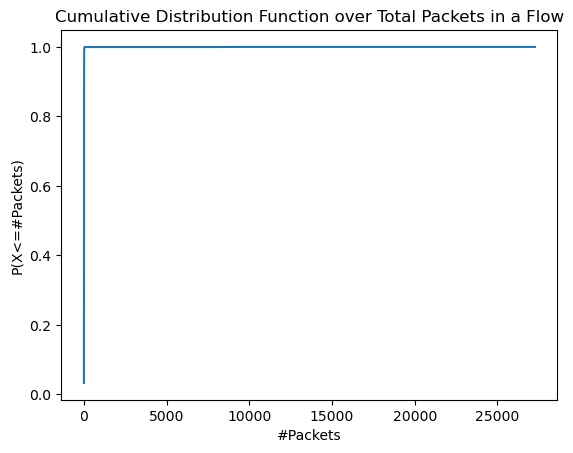

In [38]:
tmp=df.groupby('flow')['tv_sec'].count().value_counts()
tmp=tmp.sort_index().cumsum()
tmp = tmp/tmp.max()
# tmp.sort_values()
# tmp.index = tmp.index.map(np.log10)
def plot_cdf(x):
  plt.title('Cumulative Distribution Function over Total Packets in a Flow')
  plt.xlabel("#Packets")
  plt.ylabel(r"P(X<=#Packets)")
  # print(x)
  plt.plot(x)
plot_cdf(tmp)

In [39]:
df.index.nunique()

48058

In [40]:
df.to_parquet(f'data/iec104.parquet')